The purpose of this code is to quantify the size and number of synuclein inclusions for each image.

Import Libraries

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
model = models.Cellpose(model_type='cyto')

Define Sub Functions

In [26]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1



In [ ]:
def analyze_image(image_path, basename):
   
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    
    green_channel = np.squeeze(image)
    if (image_squeezed.ndim == 3):
        green_channel = image_squeezed[1]

    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)


    # green_channel_remove_inclusions = np.where(green_channel < 0.8, green_channel, 0) # remove inclusions
    # green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=10) # blur

    # Detect cells in the green channel
    # masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=300, channels=[0, 0])
    masks = green_channel > 0.05
    # exclude small objects
    masks = remove_small_objects(masks, min_size=100)
    labeled_cells = label(masks)
    # print number of cells
    print("Number of cells: ", len(np.unique(labeled_cells)) - 1)
    print("Segmented Cells")
    show_image(labeled_cells)


    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []
    inclusion_counter_cells = []
    inclusions_image_list = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        cell_counter.append(i)
        cell_size.append(cell.area)
        
        mask = labeled_cells == cell.label
        
        applied_mask_blurred = gaussian(green_channel, sigma=5) * mask
        applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
        
        # normalize 
        applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

        # calculate statistics
        mean_intensity = np.mean(applied_mask_eliminate_background)
        median_intensity = np.median(applied_mask_eliminate_background)
        q1 = np.percentile(applied_mask_eliminate_background, 25)
        q3 = np.percentile(applied_mask_eliminate_background, 75)
        
        hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
        
        applied_mask = green_channel * mask
        # 0.4 is an empirical value that seems to work well
        if q3 < 0.4 and len(bin_edges) > 20:
            # the population is skewed to the left, indicating that there are inclusions
            threshold = max(threshold_otsu(applied_mask),0.7) # use otsu thresholding to find the threshold
        elif q3 >= 0.9:
            # definitely no inclusions
            threshold = 1
        else:
            # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
            threshold = 0.99
        
        inclusions = applied_mask > threshold # apply the threshold
        inclusions_labeled = label(inclusions)
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10 and inclusion.area < 1500] # filter out inclusions that are too small or too large
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        if len(inclusion_areas) > 0:
            # print("Threshold: ", threshold)
            # print("Bin count", len(bin_edges))

            # plt.hist(applied_mask_eliminate_background, bins='fd')  
            # plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
            # plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
            # plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
            # plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
            # plt.legend()
            # plt.title("Intensity histogram")
            # plt.show()

            # print("Inclusion Areas: ", inclusion_areas)
            # show_image(inclusions)
            print(inclusion_areas)
            inclusions_image_list.append(inclusions)


            
        
        # store results
        total_inclusion_areas.append(total_inclusion_area)
        num_inclusions.append(len(inclusion_areas))
        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))
        inclusion_counter_cells.append([i] * len(inclusion_areas))
        average_inclusion_areas.append(average_inclusion_area)
    
    # combine all inclusion images
    all_inclusions = np.sum(inclusions_image_list, axis=0)
    if len(inclusions_image_list) > 0:
        show_image(all_inclusions)
    # analysis by image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Cells": [len(cell_counter)],
        "Average_Inclusion_Count": [np.sum(num_inclusions)/len(cell_counter)],
    })
    
    # analysis by cell
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })
    
    # analysis by inclusion
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Cell": np.concatenate(inclusion_counter_cells),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [28]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion.xlsx", index=False)

Define Main Function

In [29]:
# folders = ['100424_1K_WT_3K_tiles/new settings','101124_1K_WT_3K_tiles','101824_1k_wt_3k_tiles','120624_1k_wt_3k_tiles','121324_1k_wt_3k_tiles']
folders = ['022625_CH_Spermine_Hex/1K']

1K_OA_01.czi
Green Channel


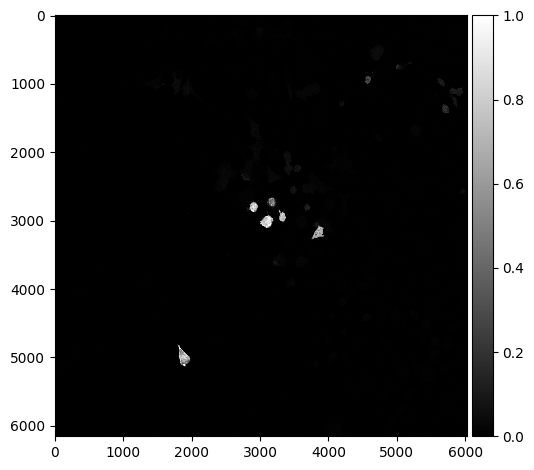

Number of cells:  31
Segmented Cells


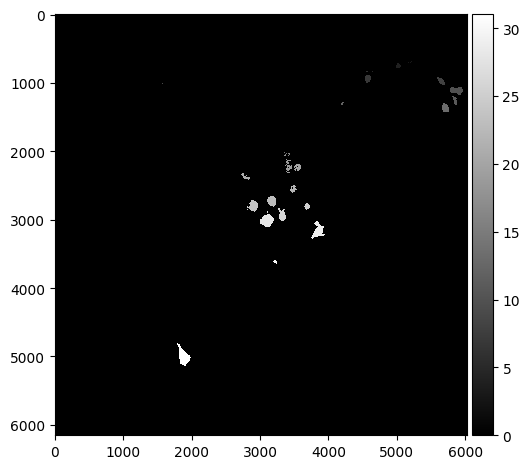

[587.]
[520.  14. 122.  18. 520. 760.  42.  25.]
[529. 556.]


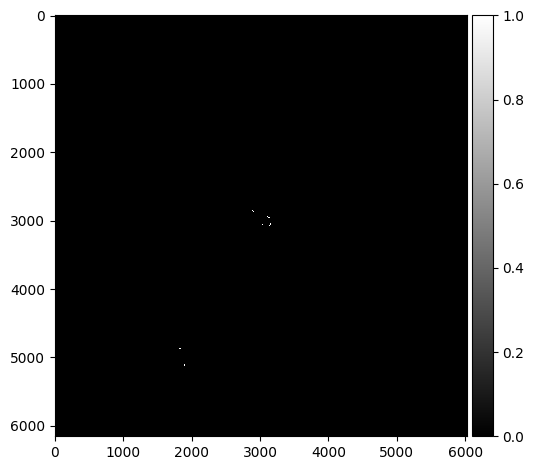

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_Spermine_1000uM_OA_01.czi
Green Channel


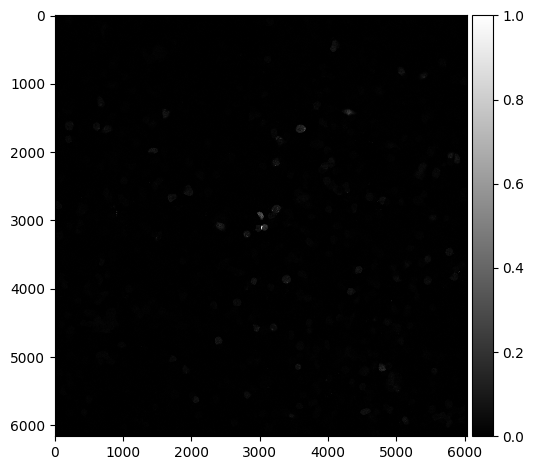

Number of cells:  65
Segmented Cells


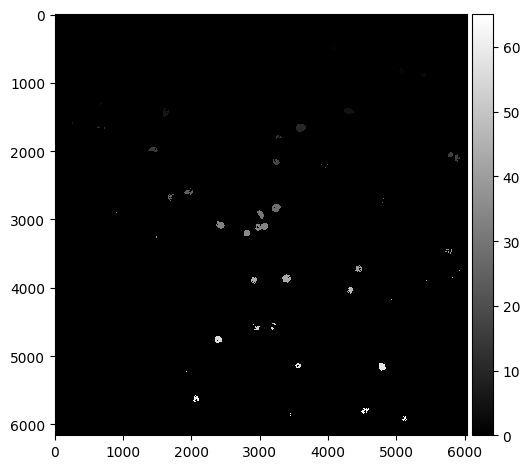

[466.]


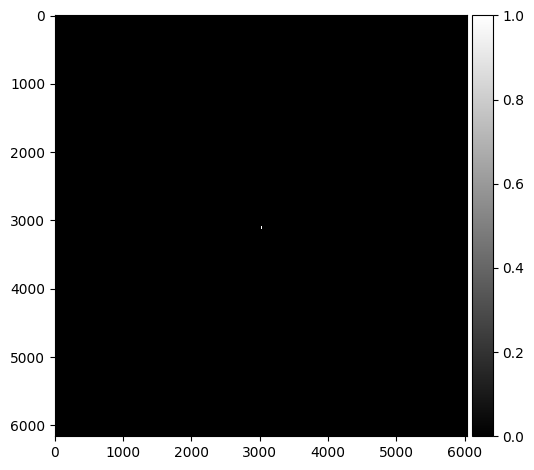

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [30]:
for i in range(len(folders)):
    analyze_all_images(folders[i])
